# Data Source

The dataset is collected from [Yelp Open Dataset](https://www.yelp.com/dataset) twice in year 2017 and 2018 respectively. The [Dataset Documentation](https://www.yelp.com/dataset/documentation/main) contains information on the structure of the dataset.

In [1]:
# Import python packages
import us
import sys
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from uszipcode import SearchEngine
from gensim.utils import simple_preprocess

## Business Data

In [2]:
# Read in 2017 and 2018 data
business_2017 = pd.read_json('business_2017.json', lines=True)
business_2018 = pd.read_json('business_2018.json', lines=True)

In [3]:
# Print the dimension of data
business_2017.shape

(174567, 15)

In [4]:
# Display first few row of business data
business_2017.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


## Merge Data

In [5]:
# Rename is_open columns
business_2017.rename(columns={'is_open':'is_open_2017'}, inplace=True)
business_2018.rename(columns={'is_open':'is_open_2018'}, inplace=True)

In [6]:
# Filter columns in 2018 business data
var_to_keep = ['business_id', 'is_open_2018']
business_2018 = business_2018[var_to_keep]

In [7]:
# Merge two dataframe based on business id
business = business_2017.merge(business_2018, how='inner', on='business_id')
business.shape

(159490, 16)

## Create Bankruptcy Label

In [8]:
# Extract all open business in 2017 and create bankruptcy label
business_df = business[business['is_open_2017'] == 1].reset_index().drop('index', axis=1)
business_df['isBankrupt'] = (business_df['is_open_2017'] != business_df['is_open_2018']).astype(int)

In [9]:
business_df.shape

(133828, 17)

## Extract Restaurant Data

In [10]:
# Filter restaurant data
business_df = business_df[business_df['categories'].apply(lambda row: 'Restaurants' in str(row))]
business_df.shape

(36512, 17)

## Extract United States Restaurants

In [11]:
# Keep only US restaurant data
us_states = us.states.mapping('name','abbr')
business_df = business_df[business_df['state'].apply(lambda row: row in us_states.values())]
business_df.shape

(22832, 17)

In [12]:
# Compute the count of each US state
state_count = business_df['state'].value_counts()
state_count

AZ    7183
NV    4780
OH    3695
NC    2837
PA    2655
WI    1100
IL     434
SC     138
NY       9
AK       1
Name: state, dtype: int64

In [13]:
# Keep only the US states with most number of restaurant
state_to_keep = state_count.index[0]
business_df = business_df[business_df['state'].apply(lambda row: row == state_to_keep)]
business_df.shape

(7183, 17)

In [14]:
# Extract restaurant ids from business data
restaurant_ids = business_df['business_id'].tolist()

## Review Data

In [16]:
# Count the number of line in review data
! wc -l review_2017.json

5261669 review_2017.json


In [17]:
# Save the review line count into a python variable and read in dataset using pandas reader
review_count = 5261669
review_reader = pd.read_json('review_2017.json', lines=True, chunksize=50000)

In [18]:
# Define function that filters the dataset using loop
def df_filter(reader, num_line):
    
    # Calculate the number of iteration required
    if num_line % reader.chunksize == 0:
        num_iteration = num_line // reader.chunksize
    else: 
        num_iteration = num_line // reader.chunksize + 1

    # Loop through the dataset and filter all restaurant business
    for i in range(num_iteration):
        temp = next(reader)
        temp = temp[temp['business_id'].apply(lambda row: row in restaurant_ids)]
        
        # Append the resulting dataframe into the original one if already exists
        try:
            df = pd.concat([df, temp])
        except:
            df = temp
    
    return df

In [19]:
%%time
# Filter the review data
review_df = df_filter(review_reader, review_count)
print(review_df.shape)

(781473, 9)
Wall time: 20min 11s


In [20]:
# Save the resulting datasets into csv files
business_df.to_csv('yelp_business.csv', index=False)
review_df.to_csv('yelp_review.csv', index=False)

# Clean Business Data

In [2]:
# Read business data
business = pd.read_csv('yelp_business.csv')
business.shape

(7183, 17)

In [3]:
# Look at first few rows of data
business.head()

,address,attributes,business_id,categories,city,hours,is_open_2017,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,is_open_2018,isBankrupt
0,719 E Thunderbird Rd,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"['Fast Food', 'Burgers', 'Restaurants']",Phoenix,{},1,33.607070,-112.064382,McDonald's,NaN,85022.0,10,1.0,AZ,1,0
1,"777 E Thunderbird Rd, Ste 107","{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"['Burgers', 'Restaurants']",Phoenix,"{'Monday': '11:00-22:00', 'Tuesday': '11:00-22...",1,33.607310,-112.063404,Charr An American Burger Bar,NaN,85022.0,232,3.0,AZ,1,0
2,1635 E Camelback Rd,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"['Restaurants', 'Burgers', 'Fast Food']",Phoenix,"{'Monday': '5:00-23:00', 'Tuesday': '5:00-23:0...",1,33.508765,-112.046240,McDonald's,NaN,85016.0,34,3.0,AZ,1,0
3,NaN,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"['Marketing', ""Men's Clothing"", 'Restaurants',...",Phoenix,"{'Monday': '8:00-17:00', 'Tuesday': '8:00-17:0...",1,33.449967,-112.070223,Caviness Studio,NaN,85001.0,4,5.0,AZ,1,0
4,"8140 N Hayden Rd, Ste H115","{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...",Scottsdale,"{'Tuesday': '17:00-22:00', 'Friday': '17:00-22...",1,33.555212,-111.900456,Tandoori Times Indian Bistro,NaN,85258.0,263,3.5,AZ,1,0


In [4]:
# Make a copy of raw dataset
business_df = business.copy()

## Check Duplicates

In [5]:
# Check row duplicates
print(business_df.shape)
print(business_df.drop_duplicates().shape)

(7183, 17)
(7183, 17)


In [6]:
# Check business_id duplicates
print(len(business_df['business_id']))
print(len(business_df['business_id'].unique()))

7183
7183


## Check Missing Values

In [7]:
# Mark invisible missing values
business_df = business_df.replace(['{}','[]'], np.nan)

In [8]:
# Check NA's before cleaning
business_df.isna().sum().sort_values(ascending=False)

neighborhood    7183
hours           1397
address           75
attributes        56
postal_code        8
is_open_2017       0
business_id        0
categories         0
city               0
isBankrupt         0
latitude           0
is_open_2018       0
name               0
review_count       0
stars              0
state              0
longitude          0
dtype: int64

In [9]:
# Drop variables
business_df = business_df.drop(['neighborhood', 'hours', 'address'], axis=1)
business_df.shape

(7183, 14)

In [10]:
# Drop observations
business_df = business_df.dropna(axis=0, how='any')
business_df.shape

(7122, 14)

In [11]:
# Check if NAs are being handled
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
dtype: int64

## Check City

In [12]:
# Check the count of each city
business_df['city'].unique()

array(['Phoenix', 'Scottsdale', 'Mesa', 'Laveen', 'Chandler', 'Glendale',
       'Avondale', 'Sun City', 'Peoria', 'Litchfield Park', 'El Mirage',
       'Gilbert', 'Tempe', 'Goodyear', 'Surprise', 'Cave Creek', 'MESA',
       'Paradise Valley', 'Sun City West', 'Fountain Hills', 'Ahwatukee',
       'Tolleson', 'Carefree', 'Central City', 'Scottdale', 'Sun Lakes',
       'Youngtown', 'Higley', 'Central City Village', 'Guadalupe',
       'Mesa AZ', 'Fort McDowell', 'Anthem', 'Waddell', 'Laveen Village',
       'Phoenix Valley', 'Glendale Az', 'Schottsdale', 'Phx'],
      dtype=object)

## Check Postal Code

In [13]:
# Convert Postal Code from float to int 
business_df['postal_code'] = business_df['postal_code'].astype(int)

In [14]:
# Check all unique postal codes
business_df['postal_code'].unique()

array([85022, 85016, 85001, 85258, 85035, 85204, 85051, 85029, 85013,
       85339, 85004, 85248, 85044, 85215, 85306, 85323, 85224, 85373,
       85381, 85286, 85032, 85255, 85262, 85201, 85019, 85340, 85335,
       85251, 85249, 85233, 85296, 85298, 85382, 85006, 85206, 85281,
       85392, 85053, 85210, 85282, 85054, 85338, 85308, 85050, 85304,
       85379, 85305, 85301, 85085, 85014, 85202, 85302, 85284, 85283,
       85331, 85012, 85254, 85297, 85351, 85388, 85226, 85042, 85383,
       85295, 85209, 85018, 85020, 85040, 85017, 85033, 85208, 85374,
       85207, 85023, 85234, 85086, 85008, 85009, 85303, 85048, 85024,
       85253, 85260, 85043, 85266, 85212, 85027, 85034, 85083, 85236,
       85015, 85021, 85003, 85345, 85041, 85378, 85375, 85268, 85310,
       85259, 85007, 85225, 85028, 85205, 85395, 85250, 85257, 85353,
       85377, 85037, 85256, 85213, 85203, 85307, 85031, 85363, 85287,
       85073, 85005, 85280, 85058, 85264, 85821, 85252, 85355, 84295,
       85734, 85064,

## Retrieve City and County

In [15]:
%%time
# Find city and county based on zipcode
search = SearchEngine() # Create an instance of uszipcode search engine
business_df['city'] = business_df['postal_code'].apply(lambda x: search.by_zipcode(str(x)).major_city)
business_df['county'] = business_df['postal_code'].apply(lambda x: search.by_zipcode(str(x)).county)

Wall time: 14.3 s


In [16]:
# Check all unique values of cities and counties
print(business_df['city'].unique())
print(business_df['county'].unique())

['Phoenix' 'Scottsdale' 'Mesa' 'Laveen' 'Chandler' 'Glendale' 'Avondale'
 'Sun City' 'Peoria' 'Litchfield Park' 'El Mirage' 'Gilbert' 'Tempe'
 'Goodyear' 'Surprise' 'Cave Creek' 'Paradise Valley' 'Higley'
 'Sun City West' 'Fountain Hills' 'Tolleson' 'Carefree' 'Youngtown' None
 'Fort Mcdowell' 'Waddell' 'Tucson']
['Maricopa County' None 'Pima County']


In [17]:
# Check all missing values
business_df.isna().sum().sort_values(ascending=False)

county          4
city            4
isBankrupt      0
is_open_2018    0
state           0
stars           0
review_count    0
postal_code     0
name            0
longitude       0
latitude        0
is_open_2017    0
categories      0
business_id     0
attributes      0
dtype: int64

In [18]:
# Check missing cities and countiess
business_df[business_df['city'].isna()]

,attributes,business_id,categories,city,is_open_2017,latitude,longitude,name,postal_code,review_count,stars,state,is_open_2018,isBankrupt,county
2472,"{'RestaurantsTableService': False, 'GoodForMea...",9h2FCxdB5uk4bjX3P47L9g,"['Breakfast & Brunch', 'Sandwiches', 'Delis', ...",None,1,33.711515,-112.111381,Jersey Mike's Subs,85058,78,4.0,AZ,1,0,None
3321,"{'RestaurantsTableService': False, 'GoodForMea...",LBAkHJJfCoDj9aa5sc0Mxw,"['Fast Food', 'Ice Cream & Frozen Yogurt', 'Bu...",None,1,33.423351,-111.939747,Steak 'n Shake,85821,232,2.5,AZ,1,0,None
4119,"{'GoodForMeal': {'dessert': False, 'latenight'...",MBYMEdAI-ZlE-gr61fqs8Q,"['Breakfast & Brunch', 'Cafes', 'Restaurants',...",None,1,33.305359,-111.754638,"First Watch - Breakfast, Brunch & Lunch",84295,38,4.0,AZ,1,0,None
6373,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",DZbMvBWb3OjC9045XLHmVg,"['Bars', 'Nightlife', 'American (New)', 'Chick...",None,1,33.464146,-112.388143,Native Grill & Wings,85394,49,3.0,AZ,1,0,None


In [19]:
# Drop observations that contain invalid postal codes
business_df = business_df.dropna()
business_df.shape

(7118, 15)

In [20]:
# Check if the observation with invalid zipcodes are removed
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
county          0
dtype: int64

## Check County

In [21]:
# Check the number of restaurants in the county
business_df['county'].value_counts()

Maricopa County    7117
Pima County           1
Name: county, dtype: int64

In [22]:
# Remove the only observation in pima county
business_df = business_df[~(business_df['county'] == 'Pima County')]
business_df.shape

(7117, 15)

In [23]:
# Check if the observation is removed
business_df['county'].value_counts()

Maricopa County    7117
Name: county, dtype: int64

## Check Geographic Coordinates

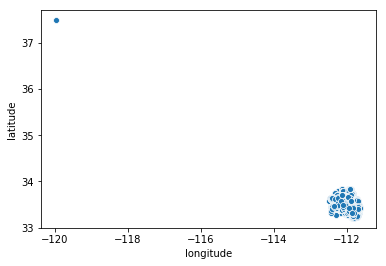

In [24]:
# Plot the location of all restaurants
sns.scatterplot('longitude', 'latitude', data=business_df);

In [25]:
# Remove the restaurant that is far away from the rest of the population
business_df = business_df[~((business_df['longitude'] < -119) & (business_df['latitude'] > 37))]
business_df.shape

(7116, 15)

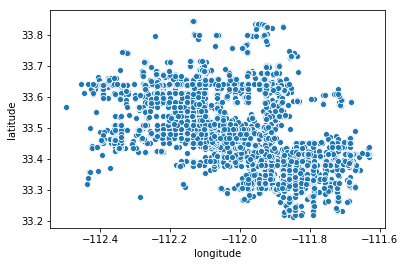

In [26]:
# Check if the outlier is removed
sns.scatterplot('longitude', 'latitude', data=business_df);

In [27]:
# Check NA's after cleaning
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
county          0
dtype: int64

In [28]:
# Drop unwanted columns
business_df = business_df.drop(columns=['is_open_2017', 'is_open_2018'])
business_df.shape

(7116, 13)

In [29]:
# Look at first few rows of finalized business data
business_df.head()

,attributes,business_id,categories,city,latitude,longitude,name,postal_code,review_count,stars,state,isBankrupt,county
0,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"['Fast Food', 'Burgers', 'Restaurants']",Phoenix,33.607070,-112.064382,McDonald's,85022,10,1.0,AZ,0,Maricopa County
1,"{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"['Burgers', 'Restaurants']",Phoenix,33.607310,-112.063404,Charr An American Burger Bar,85022,232,3.0,AZ,0,Maricopa County
2,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"['Restaurants', 'Burgers', 'Fast Food']",Phoenix,33.508765,-112.046240,McDonald's,85016,34,3.0,AZ,0,Maricopa County
3,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"['Marketing', ""Men's Clothing"", 'Restaurants',...",Phoenix,33.449967,-112.070223,Caviness Studio,85001,4,5.0,AZ,0,Maricopa County
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...",Scottsdale,33.555212,-111.900456,Tandoori Times Indian Bistro,85258,263,3.5,AZ,0,Maricopa County


# Clean Review Data

In [30]:
# Read review data
review = pd.read_csv('yelp_review.csv')
review.shape

(781473, 9)

In [31]:
# Look at first few rows of data
review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,We always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,"This place is always so dirty and grimy, been ...",6,ssuXFjkH4neiBgwv-oN4IA
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,Holy portion sizes! You get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,xatycgntu_F_Ioyny3iflw,4,Flavor was actually pretty good. Not used to e...,0,vaXJ7-xLrnD6FAEhUqYKwQ
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,Z7U7MMef6Tbj_ZbSFzLRUw,5,This is place very great flavor. Server was on...,1,vaXJ7-xLrnD6FAEhUqYKwQ


In [32]:
# Make a copy of raw dataset
review_df = review.copy()

## Check Duplicates

In [33]:
# Check row duplicates
print(review_df.shape)
print(review_df.drop_duplicates().shape)

(781473, 9)
(781473, 9)


## Check Missing Values

In [34]:
# Check NA's
review_df.isna().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

## Calculate Number of Words

In [35]:
# Calculate number of words
review_df['review_length'] = review_df['text'].apply(lambda doc: len(str(doc).split(' ')))

## Clean Text 

In [36]:
def keep_token(x):
    # Drop word that do not belong to the required part of speech
    pos_to_keep = ['ADJ', 'ADV', 'NOUN', 'VERB']
    if x.pos_ not in pos_to_keep:
        return False
    
    # Keep only alphabetical words
    if x.is_alpha == False:
        return False
    
    # Remove stopwords
    if x.is_stop == True:
        return False
    
    # Keep the token if it does not get filtered out
    return True

In [37]:
# Load spacy nlp model
nlp = spacy.load('en_core_web_sm')

# Define function that lemmatize and remove
clean_text = lambda x: ' '.join([word.lemma_ for word in nlp(u'{}'.format(x)) if keep_token(word)])

In [38]:
%%time
# Clean text
review_df['clean_text'] = review_df['text'].apply(clean_text)

Wall time: 5h 41min 16s


In [39]:
%%time
# Remove accents from all words
review_df['clean_text'] = review_df['clean_text'].apply(lambda doc: ' '.join(simple_preprocess(str(doc), deacc=True)))

Wall time: 1min 18s


In [40]:
# Drop unwanted column
review_df = review_df.drop(columns = ['review_id', 'text', 'user_id'])
review_df.shape

(781473, 9)

In [41]:
# Look at first few rows of finalized review data
review_df.head()

,business_id,cool,date,funny,stars,useful,review_length,clean_text
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,1,3,81,chevo chandler delicious ahwatukee different r...
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,1,6,21,place dirty grimy twice service horrible
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,4,0,25,holy portion size lot bang buck service super ...
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,4,0,60,flavor actually pretty good eat menudo tortill...
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,5,1,94,place great flavor thing ask bring chip salsa ...


In [42]:
review_df.isna().sum()

business_id      0
cool             0
date             0
funny            0
review_id        0
stars            0
useful           0
review_length    0
clean_text       0
dtype: int64

# Export Cleaned Datasets

In [43]:
# Export datasets
business_df.to_csv('clean_business.csv', index=False)
review_df.to_csv('clean_review.csv', index=False)